In [1]:
import json
import time
import pandas as pd
from collections import Counter

In [2]:
# Basic data files and paths
TOP_100_PATH = '../data/popular_100_memes.csv'
TOP_100 = pd.read_csv(TOP_100_PATH, encoding = "ISO-8859-1")
DATA_PATH = '../data/memes/'

STATS_PATH = '../data/statistics.json'
with open(STATS_PATH, 'r') as f:
    STATS = json.load(f)
print(TOP_100.head())

          ID                   Name  \
0  112126428   Distracted Boyfriend   
1     438680  Batman Slapping Robin   
2   87743020            Two Buttons   
3  181913649    Drake Hotline Bling   
4      61579    One Does Not Simply   

                                     Alternate Names  
0  distracted bf, guy checking out another girl, ...  
1                                                NaN  
2  2 red buttons, choice button, which button, da...  
3  drakeposting, drakepost, drake hotline approve...  
4  one does not simply walk into morder, lord of ...  


In [3]:
memes_count = Counter(STATS['memes'])
print(len(STATS['memes']))
for f, c in memes_count.most_common():
    print(f, c)

99
Bad-Luck-Brian.json 32141
One-Does-Not-Simply.json 26186
Philosoraptor.json 19971
Boardroom-Meeting-Suggestion.json 18164
Futurama-Fry.json 17325
First-World-Problems.json 17272
The-Most-Interesting-Man-In-The-World.json 15850
Batman-Slapping-Robin.json 14802
Bad-Pun-Dog.json 13194
X-X-Everywhere.json 12985
Expanding-Brain.json 12826
Two-Buttons.json 12232
But-Thats-None-Of-My-Business.json 11097
Ancient-Aliens.json 10555
Creepy-Condescending-Wonka.json 10374
Grumpy-Cat.json 9569
Y-U-No.json 9370
The-Rock-Driving.json 9286
That-Would-Be-Great.json 8600
Waiting-Skeleton.json 8592
Change-My-Mind.json 8563
Leonardo-Dicaprio-Cheers.json 8377
10-Guy.json 8258
Captain-Picard-Facepalm.json 8105
Matrix-Morpheus.json 7833
Third-World-Skeptical-Kid.json 7782
Confession-Bear.json 7778
Am-I-The-Only-One-Around-Here.json 7291
Success-Kid.json 7074
Hide-the-Pain-Harold.json 6973
Roll-Safe-Think-About-It.json 6948
Evil-Toddler.json 6106
Awkward-Moment-Sealion.json 6101
Face-You-Make-Robert-Downey-

In [5]:
selected_memes = [
    'Woman-Yelling-At-Cat.json', 
    'Left-Exit-12-Off-Ramp.json', 
    'Surprised-Pikachu.json',    
    'Is-This-A-Pigeon.json',  
    'Drake-Hotline-Bling.json', 
    'Blank-Nut-Button.json', 
    'One-Does-Not-Simply.json',
    'Change-My-Mind.json', 
    'Roll-Safe-Think-About-It.json', 
    'Leonardo-Dicaprio-Cheers.json' 
]
def open_data(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

memes_data = []
y = []

for i,meme in enumerate(selected_memes):
    data = open_data(DATA_PATH + meme)
    for j, d in enumerate(data):
        if ''.join(d['boxes']).strip() != '':
            memes_data.append(d)
            y.append(i)
            if j > 3000:
                break

In [6]:
print(memes_data[0])
print(len(memes_data))
print(len(y))

{'url': 'https://i.imgflip.com/3z10rd.jpg', 'post': 'https://imgflip.com/i/3z10rd', 'metadata': {'views': '366', 'img-votes': '1', 'title': 'What are you doing me?', 'author': 'mjelliott80'}, 'boxes': ["me: i don't know what to do with my life", "me to me: and i don't want to see it"]}
29706
29706


In [7]:
# Preprocessing data for modelling
from nltk import sent_tokenize, word_tokenize
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [8]:
# functions to preprocess data into a list of words, blocks separated by |
def parse_text(text):
    text = text.lower().strip()
    return word_tokenize(text)

def parse_blocks(blocks):
    result = []
    for i,b in enumerate(blocks):
        result.extend(parse_text(b))
        if i < len(blocks) - 1:
            result.extend('|')
    return result

In [9]:
X_words = [parse_blocks(meme['boxes']) for meme in memes_data]
print(X_words[0])

['me', ':', 'i', 'do', "n't", 'know', 'what', 'to', 'do', 'with', 'my', 'life', '|', 'me', 'to', 'me', ':', 'and', 'i', 'do', "n't", 'want', 'to', 'see', 'it']


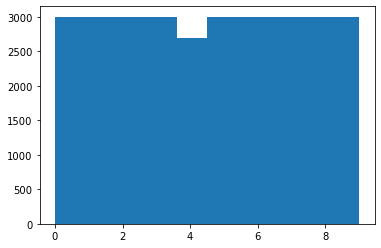

In [11]:
X_text = [' '.join(text) for text in X_words]
plt.hist(y)
plt.show()

In [ ]:
# taking sample of text to optimize
X_sample, _, y_sample, _ = train_test_split(X_text, y, train_size=0.2, test_size=0.8)

# optimizing tfidf with pipeline and gridsearch: takes a very very long time to run
pipeline = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('clf', LogisticRegression())
])

parameters = {
    'tfidf__max_df':(0.5,0.75,1.0),
    'tfidf__min_df':(0.2,1,3),
    'tfidf__ngram_range':((1,1),(1,2)),
    'clf__C': (0.2,0.5,0.8,1.0),
    'clf__tol': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__solver': ('sag','saga','lbfgs')
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=3) #perform gridsearch
grid_search.fit(X_sample, y_sample)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 2040 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 17.8min


In [ ]:
# implementing best results
vectorizer = TfidfVectorizer(max_df=0.5, min_df=3, ngram_range=(1,1))

vectors = vectorizer.fit_transform(X_text)
print(vectors.shape)
scaled_vectors = StandardScaler().fit_transform(vectors.toarray())

model = LogisticRegression(C=1.0,penalty='l2',solver='lbfgs', max_iter=100, tol=0.00001)
X_train, X_test, y_train, y_test = train_test_split(scaled_vectors, y, train_size=0.8, test_size=0.2)
model = model.fit(X_train, y_train)
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))

(74152, 11731)


In [ ]:
# implementing normal result
vectorizer = TfidfVectorizer()

vectors = vectorizer.fit_transform(X_text)
print(vectors.shape)
scaled_vectors = StandardScaler().fit_transform(vectors.toarray())

model = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(scaled_vectors, y, train_size=0.8, test_size=0.2)
model = model.fit(X_train, y_train)
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))

(74152, 36022)


In [ ]:
plt.hist(pred)
plt.show()